## Alloy optimization

We use multi-objective optimization to select the cheapest alloys exhibiting an enhanced *X* property after mixing. This is a useful problem for illustrating flexibility in defining an optimization problem in MOSA.

The pure, fictitious elements have symbols in the A...Z range. The dataset used to obtain the *X* property and the cost associated with the pure elements was generated by the Python code below:
```
from numpy import random

component=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
x0=0.5
x1=12.6
x=[(x0*k+x1)+random.uniform(0.0,5.0) for k in range(len(component))]
cost=[random.uniform(5.0,500.0) for k in range(len(component))]   

with open("dataset","w") as f:
    f.write("Component,X,Cost\n")
    
    for i in range(len(component)):
        f.write("%s,%f,%f\n" % (component[i],x[i],cost[i]))
```

In [1]:
from mosa import Anneal
from time import time
from pandas import read_csv
%matplotlib inline

In [2]:
df=read_csv("dataset")

### Translating the alloy optimization problem into Python code

A Python function *fobj* implements the problem. A solution is taken as its only argument. The solution is 
a Python dictionary with the same two keys as the population. In the alloy optimization problem, the first 
element in the "Component" key is the matrix element, while the second is the alloying element. "Concentration" gives the 
relative amount of the alloying element in the alloy. *fobj* must return a list containing the values of the objectives, not a tuple or any other Python object.

Both the *X* property and the cost of pure elements are loaded from the *pandas* dataframe defined above. Notice that both the *X* property and the cost of the alloy results from a simple mixing rule. Also, maximizing *X* is equivalent to minimizing 
-*X*, that is why -*x* is returned by *fobj*.

In [3]:
def fobj(solution):
    elem1=df[df.Component==solution["Component"][0]]
    elem2=df[df.Component==solution["Component"][1]]
    conc=solution["Concentration"]
    x1=elem1.X.values[0]
    cost1=elem1.Cost.values[0]
    x2=elem2.X.values[0]
    cost2=elem2.Cost.values[0]  
    x=x1*(1.0-conc)+x2*conc
    cost=cost1*(1.0-conc)+cost2*conc
        
    return [-x,cost]

### Initialization

An *Anneal* object is created. Then attributes of the *opt* object are set to control how the optimization process will take place.

In [4]:
opt=Anneal()

--------------------------------------------------
    MULTI-OBJECTIVE SIMULATED ANNEALING (MOSA)    
--------------------------------------------------
      Developed by Dr. Roberto G. A. Veiga
   Universidade Federal do ABC (UFABC), Brazil




In [5]:
opt.population={"Component":df.Component.values.tolist(),"Concentration":None}
opt.initial_temperature=1.0
opt.number_of_temperatures=100
opt.number_of_iterations=200
opt.objective_weights=[(df.X.values.max()-df.X.values.min()),(df.Cost.values.max()-df.Cost.values.min())]
opt.archive_size=1000
opt.maximum_archive_rejections=1000
opt.number_of_solution_elements={"Component":2,"Concentration":1}
opt.solution_key_selection_weights={"Component":1.0,"Concentration":4.0}
opt.no_repeated_elements={"Component":True}
opt.exchange_probability={"Component":1.0,"Concentration":1.0}
opt.mc_step_size={"Concentration":0.05}
opt.solution_bounds={"Concentration":[0.0,0.1]}

IMPORTANT: Restarting from previous runs is disabled.

In [6]:
opt.restart=False

### Run 1

The optimization process actually occurs when the *evolve* method is called with *fobj* as argument.

In [7]:
opt.archive_file="archive1.json"
start=time()
opt.evolve(fobj)
end=time()
print("   Elapsed time: %f s" % (end-start))
archive1=opt.copyx()

--- BEGIN: Evolving a solution ---

Initializing an empty archive...
Done!
------
Population/solution keys:
    ['Component']:
        Number of elements in the solution: 2
        Discrete sampling space
        Number of elements in the population: 26
        Elements cannot be repeated in the solution: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population, using a triangular distribution: 13
    ['Concentration']:
        Number of elements in the solution: 1
        Continuous sampling space
        Boundaries: [0.0000,0.1000]
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from soluti

### Output 1

Below we print the content of the first solution archive, we also print some basic statistics, and then plot *X* vs. *Cost*.

In [8]:
opt.printx()

===
Solutions:
1) {'Component': ['I', 'Z'], 'Concentration': 0.014566237260621201}
2) {'Component': ['I', 'Z'], 'Concentration': 0.07022478295546672}
3) {'Component': ['Z', 'M'], 'Concentration': 0.02680314378081919}
4) {'Component': ['Z', 'M'], 'Concentration': 0.0659010170444572}
5) {'Component': ['Z', 'M'], 'Concentration': 0.05679510957055954}
6) {'Component': ['Z', 'M'], 'Concentration': 0.016365217441701205}
7) {'Component': ['Z', 'M'], 'Concentration': 0.06246546454837636}
8) {'Component': ['Z', 'M'], 'Concentration': 0.08420948514871665}
9) {'Component': ['Z', 'H'], 'Concentration': 0.054024025391040426}
10) {'Component': ['Z', 'L'], 'Concentration': 0.009170006711197859}
11) {'Component': ['I', 'K'], 'Concentration': 0.04532486716645048}
12) {'Component': ['I', 'K'], 'Concentration': 0.010432877533127653}
13) {'Component': ['Z', 'I'], 'Concentration': 0.019838898455819653}
14) {'Component': ['Z', 'Y'], 'Concentration': 0.09922056292519991}
15) {'Component': ['Z', 'R'], 'Concen

In [9]:
opt.printstats()

===
Objective function 0: 
    Minimum: -28.327597
    Maximum: -17.750491
    Average: -26.999313
===
Objective function 1: 
    Minimum: 26.075838
    Maximum: 400.664097
    Average: 107.677106


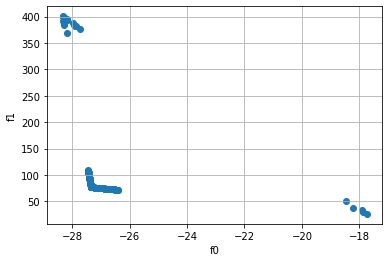

In [10]:
opt.plotfront()

### Run 2

Second optimization run starts from scratch. It means that, by calling the *evolve* method, the previous archive is lost.

In [11]:
opt.archive_file="archive2.json"
start=time()
opt.evolve(fobj)
end=time()
print("   Elapsed time: %f s" % (end-start))
archive2=opt.copyx()

--- BEGIN: Evolving a solution ---

Initializing an empty archive...
Done!
------
Population/solution keys:
    ['Component']:
        Number of elements in the solution: 2
        Discrete sampling space
        Number of elements in the population: 26
        Elements cannot be repeated in the solution: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population, using a triangular distribution: 13
    ['Concentration']:
        Number of elements in the solution: 1
        Continuous sampling space
        Boundaries: [0.0000,0.1000]
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from soluti

    Number of accepted moves: 95.
    Fraction of accepted moves: 0.475000.
    Number of archive updates: 16.
    Fraction of archive updates in accepted moves: 0.168421.
------
TEMPERATURE: 0.016423
    Number of accepted moves: 82.
    Fraction of accepted moves: 0.410000.
    Number of archive updates: 2.
    Fraction of archive updates in accepted moves: 0.024390.
------
TEMPERATURE: 0.014781
    Number of accepted moves: 92.
    Fraction of accepted moves: 0.460000.
    Number of archive updates: 3.
    Fraction of archive updates in accepted moves: 0.032609.
------
TEMPERATURE: 0.013303
    Number of accepted moves: 64.
    Fraction of accepted moves: 0.320000.
    No archive update.
------
TEMPERATURE: 0.011973
    Number of accepted moves: 51.
    Fraction of accepted moves: 0.255000.
    No archive update.
------
TEMPERATURE: 0.010775
    Number of accepted moves: 106.
    Fraction of accepted moves: 0.530000.
    No archive update.
------
TEMPERATURE: 0.009698
    Number of 

    Number of accepted moves: 25.
    Fraction of accepted moves: 0.125000.
    No archive update.
------
TEMPERATURE: 0.000104
    Number of accepted moves: 14.
    Fraction of accepted moves: 0.070000.
    Number of archive updates: 2.
    Fraction of archive updates in accepted moves: 0.142857.
------
TEMPERATURE: 0.000094
    Number of accepted moves: 11.
    Fraction of accepted moves: 0.055000.
    Number of archive updates: 1.
    Fraction of archive updates in accepted moves: 0.090909.
------
TEMPERATURE: 0.000085
    Number of accepted moves: 7.
    Fraction of accepted moves: 0.035000.
    No archive update.
------
TEMPERATURE: 0.000076
    Number of accepted moves: 12.
    Fraction of accepted moves: 0.060000.
    Number of archive updates: 2.
    Fraction of archive updates in accepted moves: 0.166667.
------
TEMPERATURE: 0.000069
    Number of accepted moves: 13.
    Fraction of accepted moves: 0.065000.
    Number of archive updates: 1.
    Fraction of archive updates in 

### Output 2

Below we print the content of the second solution archive, we also print some basic statistics, and then plot *X* vs. *Cost*.

In [12]:
opt.printx()

===
Solutions:
1) {'Component': ['E', 'X'], 'Concentration': 0.07896890484512013}
2) {'Component': ['E', 'X'], 'Concentration': 0.0809667284982213}
3) {'Component': ['E', 'X'], 'Concentration': 0.08512996627937394}
4) {'Component': ['E', 'X'], 'Concentration': 0.04073479106090097}
5) {'Component': ['E', 'X'], 'Concentration': 0.07082462734192066}
6) {'Component': ['E', 'X'], 'Concentration': 0.03807369842722258}
7) {'Component': ['E', 'Y'], 'Concentration': 0.09598001129984118}
8) {'Component': ['I', 'K'], 'Concentration': 0.09007123315100111}
9) {'Component': ['I', 'K'], 'Concentration': 0.017425811863149274}
10) {'Component': ['I', 'K'], 'Concentration': 0.009795914341899567}
11) {'Component': ['I', 'K'], 'Concentration': 0.08298676326962195}
12) {'Component': ['I', 'K'], 'Concentration': 0.018104882901217673}
13) {'Component': ['I', 'K'], 'Concentration': 0.05962749076231108}
14) {'Component': ['X', 'I'], 'Concentration': 0.09284965988355019}
15) {'Component': ['X', 'Z'], 'Concentra

237) [-27.349674425562025, 79.18266785900434]
238) [-27.264965151823336, 76.33299169949375]
239) [-27.072704258915252, 75.27962031410577]
240) [-26.93488273346973, 74.52451484778379]
241) [-26.482479495940822, 72.04585879942314]
242) [-27.329137759614476, 76.68458472369359]
243) [-27.074220828633806, 75.287929394134]
244) [-27.070161791529614, 75.26569047974473]
245) [-27.159859179403433, 75.7571303160067]
246) [-26.673587773289995, 73.09291516031632]
247) [-26.94281941274216, 74.567998838283]
248) [-26.985530761886103, 74.80200853385354]
249) [-26.812509370472622, 73.85404777065187]
250) [-27.05497271998331, 75.18247161450655]
251) [-26.440030918293125, 71.81328879328112]
252) [-26.44171199987276, 71.82249921150866]
253) [-26.580567857125846, 72.58327164167652]
254) [-27.18793717389089, 75.91096584389177]
255) [-27.32175595650823, 76.6441408245362]
256) [-27.1871282556793, 75.90653389059997]
257) [-26.701080525313767, 73.24354422402952]
258) [-26.858393911955968, 74.10544295715668]
25

In [13]:
opt.printstats()

===
Objective function 0: 
    Minimum: -28.378457
    Maximum: -17.707748
    Average: -26.185819
===
Objective function 1: 
    Minimum: 23.970819
    Maximum: 400.133930
    Average: 86.351528


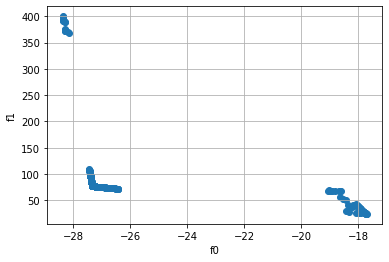

In [14]:
opt.plotfront()

### Run 3

Third optimization run also starts from scratch.

In [15]:
opt.archive_file="archive3.json"
start=time()
opt.evolve(fobj)
end=time()
print("   Elapsed time: %f s" % (end-start))
archive3=opt.copyx()

--- BEGIN: Evolving a solution ---

Initializing an empty archive...
Done!
------
Population/solution keys:
    ['Component']:
        Number of elements in the solution: 2
        Discrete sampling space
        Number of elements in the population: 26
        Elements cannot be repeated in the solution: True
        Selection weight of this key: 1.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from solution: 0.000000
        Solution sorted after change: False
        Maximum step size to select an element in the population, using a triangular distribution: 13
    ['Concentration']:
        Number of elements in the solution: 1
        Continuous sampling space
        Boundaries: [0.0000,0.1000]
        Selection weight of this key: 4.000000
        Probability of element exchange between population and solution: 100.000000
        Probability of element insertion to/deletion from soluti

    Number of accepted moves: 108.
    Fraction of accepted moves: 0.540000.
    Number of archive updates: 19.
    Fraction of archive updates in accepted moves: 0.175926.
------
TEMPERATURE: 0.020276
    Number of accepted moves: 82.
    Fraction of accepted moves: 0.410000.
    Number of archive updates: 2.
    Fraction of archive updates in accepted moves: 0.024390.
------
TEMPERATURE: 0.018248
    Number of accepted moves: 77.
    Fraction of accepted moves: 0.385000.
    Number of archive updates: 13.
    Fraction of archive updates in accepted moves: 0.168831.
------
TEMPERATURE: 0.016423
    Number of accepted moves: 97.
    Fraction of accepted moves: 0.485000.
    Number of archive updates: 8.
    Fraction of archive updates in accepted moves: 0.082474.
------
TEMPERATURE: 0.014781
    Number of accepted moves: 88.
    Fraction of accepted moves: 0.440000.
    Number of archive updates: 6.
    Fraction of archive updates in accepted moves: 0.068182.
------
TEMPERATURE: 0.0133

    Number of accepted moves: 12.
    Fraction of accepted moves: 0.060000.
    Number of archive updates: 2.
    Fraction of archive updates in accepted moves: 0.166667.
------
TEMPERATURE: 0.000177
    Number of accepted moves: 13.
    Fraction of accepted moves: 0.065000.
    No archive update.
------
TEMPERATURE: 0.000159
    Number of accepted moves: 12.
    Fraction of accepted moves: 0.060000.
    Number of archive updates: 2.
    Fraction of archive updates in accepted moves: 0.166667.
------
TEMPERATURE: 0.000143
    Number of accepted moves: 7.
    Fraction of accepted moves: 0.035000.
    Number of archive updates: 1.
    Fraction of archive updates in accepted moves: 0.142857.
------
TEMPERATURE: 0.000129
    Number of accepted moves: 15.
    Fraction of accepted moves: 0.075000.
    No archive update.
------
TEMPERATURE: 0.000116
    Number of accepted moves: 13.
    Fraction of accepted moves: 0.065000.
    No archive update.
------
TEMPERATURE: 0.000104
    Number of acc

### Output 3

Below we print the content of the third solution archive, we also print some basic statistics, and then plot *X* vs. *Cost*.

In [16]:
opt.printx()

===
Solutions:
1) {'Component': ['I', 'K'], 'Concentration': 0.005374109395795759}
2) {'Component': ['I', 'K'], 'Concentration': 0.024335228334784006}
3) {'Component': ['I', 'K'], 'Concentration': 0.008648730800619835}
4) {'Component': ['I', 'K'], 'Concentration': 0.06547131458677047}
5) {'Component': ['I', 'K'], 'Concentration': 0.014302970623909575}
6) {'Component': ['I', 'K'], 'Concentration': 0.08895312861513383}
7) {'Component': ['I', 'K'], 'Concentration': 0.024541459939917264}
8) {'Component': ['E', 'G'], 'Concentration': 0.00861665135924329}
9) {'Component': ['X', 'I'], 'Concentration': 0.07039087656404613}
10) {'Component': ['X', 'I'], 'Concentration': 0.08735718899434633}
11) {'Component': ['I', 'K'], 'Concentration': 0.02660975612201582}
12) {'Component': ['I', 'K'], 'Concentration': 0.08688354027162035}
13) {'Component': ['I', 'K'], 'Concentration': 0.05115607583102525}
14) {'Component': ['I', 'Y'], 'Concentration': 0.039677475466762646}
15) {'Component': ['I', 'Y'], 'Conce

In [17]:
opt.printstats()

===
Objective function 0: 
    Minimum: -28.371996
    Maximum: -17.711157
    Average: -26.177759
===
Objective function 1: 
    Minimum: 24.056567
    Maximum: 399.853241
    Average: 97.391638


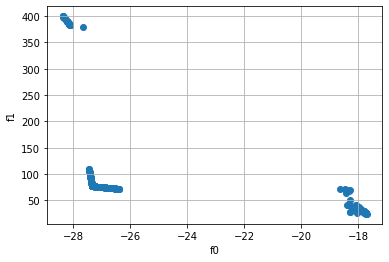

In [18]:
opt.plotfront()

### Merges the three solution archives and purges dominated solutions

Next, we merge the three solution archives and eliminate from the resulting archive the dominated solutions, printing only the non-dominated solutions and some basic statistics, and plotting again *X* vs. *Cost*. Merging archives from different runs, as you can see, provides a simple manner of performing parallel runs.

In [19]:
merged=opt.mergex([archive1,archive2,archive3])
purged=opt.purgedominated(xset=merged,delduplicated=True)
opt.savex(xset=purged,archivefile="merged_archive.json")
opt.printx(purged)

===
Solutions:
1) {'Component': ['I', 'Z'], 'Concentration': 0.07022478295546672}
2) {'Component': ['Z', 'Y'], 'Concentration': 0.09922056292519991}
3) {'Component': ['X', 'I'], 'Concentration': 0.04148420429796488}
4) {'Component': ['X', 'I'], 'Concentration': 0.011915415047892966}
5) {'Component': ['X', 'I'], 'Concentration': 0.0006630636432498199}
6) {'Component': ['X', 'I'], 'Concentration': 0.07049457672575508}
7) {'Component': ['X', 'I'], 'Concentration': 0.005804465660993685}
8) {'Component': ['X', 'I'], 'Concentration': 0.020309931258648682}
9) {'Component': ['X', 'I'], 'Concentration': 0.0184759544633864}
10) {'Component': ['X', 'I'], 'Concentration': 0.07693200157008258}
11) {'Component': ['X', 'I'], 'Concentration': 0.056419611990612684}
12) {'Component': ['X', 'I'], 'Concentration': 0.03936615508698447}
13) {'Component': ['X', 'I'], 'Concentration': 0.06558340843708399}
14) {'Component': ['X', 'I'], 'Concentration': 0.08003369055586823}
15) {'Component': ['X', 'I'], 'Concen

669) {'Component': ['X', 'I'], 'Concentration': 0.06031833743557838}
670) {'Component': ['X', 'I'], 'Concentration': 0.006264979637591914}
671) {'Component': ['X', 'I'], 'Concentration': 0.008670076607829653}
672) {'Component': ['X', 'I'], 'Concentration': 0.04727206533086678}
673) {'Component': ['X', 'I'], 'Concentration': 0.004674230014257166}
674) {'Component': ['X', 'I'], 'Concentration': 0.09782999624981563}
675) {'Component': ['X', 'I'], 'Concentration': 0.04643799596672174}
676) {'Component': ['X', 'I'], 'Concentration': 0.042380314121861835}
677) {'Component': ['X', 'I'], 'Concentration': 0.004875880555449012}
678) {'Component': ['X', 'I'], 'Concentration': 0.0828035359956879}
679) {'Component': ['X', 'I'], 'Concentration': 0.08738840644079507}
680) {'Component': ['X', 'I'], 'Concentration': 0.03533541161317669}
681) {'Component': ['X', 'I'], 'Concentration': 0.051985888418885934}
682) {'Component': ['X', 'I'], 'Concentration': 0.06146001940201899}
683) {'Component': ['X', 'I']

In [20]:
opt.printstats(purged)

===
Objective function 0: 
    Minimum: -28.378457
    Maximum: -17.707748
    Average: -26.905668
===
Objective function 1: 
    Minimum: 23.970819
    Maximum: 400.133930
    Average: 85.812233


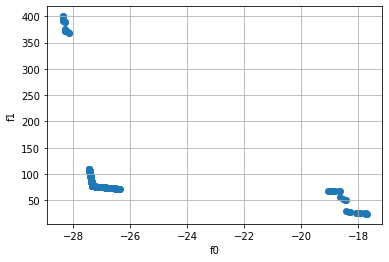

In [21]:
opt.plotfront(purged)

### Decision making

Many solutions (i.e., candidate alloys) still remain in the archive and it is hard to choose one or two out of them. 

In order to reduce the solution set to something a human being is able to deal with, first, the *trimx* method is 
used to select only the alloys that present a reasonable (according to the users needs) value of the *X* property.

In [22]:
trimmed=opt.trimx(xset=purged,thresholds=[-25.0,None])
opt.printx(trimmed)

===
Solutions:
1) {'Component': ['Z', 'Y'], 'Concentration': 0.09922056292519991}
2) {'Component': ['X', 'I'], 'Concentration': 0.04148420429796488}
3) {'Component': ['X', 'I'], 'Concentration': 0.011915415047892966}
4) {'Component': ['X', 'I'], 'Concentration': 0.0006630636432498199}
5) {'Component': ['X', 'I'], 'Concentration': 0.07049457672575508}
6) {'Component': ['X', 'I'], 'Concentration': 0.005804465660993685}
7) {'Component': ['X', 'I'], 'Concentration': 0.020309931258648682}
8) {'Component': ['X', 'I'], 'Concentration': 0.0184759544633864}
9) {'Component': ['X', 'I'], 'Concentration': 0.07693200157008258}
10) {'Component': ['X', 'I'], 'Concentration': 0.056419611990612684}
11) {'Component': ['X', 'I'], 'Concentration': 0.03936615508698447}
12) {'Component': ['X', 'I'], 'Concentration': 0.06558340843708399}
13) {'Component': ['X', 'I'], 'Concentration': 0.08003369055586823}
14) {'Component': ['X', 'I'], 'Concentration': 0.024418825213816567}
15) {'Component': ['X', 'I'], 'Conce

401) {'Component': ['X', 'I'], 'Concentration': 0.021563019019327154}
402) {'Component': ['X', 'I'], 'Concentration': 0.032956135050573716}
403) {'Component': ['X', 'I'], 'Concentration': 0.013957218664494349}
404) {'Component': ['X', 'I'], 'Concentration': 0.026709323357447808}
405) {'Component': ['X', 'I'], 'Concentration': 0.07723340055805097}
406) {'Component': ['X', 'I'], 'Concentration': 0.050100616668369846}
407) {'Component': ['X', 'I'], 'Concentration': 0.054834812661878916}
408) {'Component': ['X', 'I'], 'Concentration': 0.04820164920983969}
409) {'Component': ['X', 'I'], 'Concentration': 0.035461924313011574}
410) {'Component': ['X', 'I'], 'Concentration': 0.05072915265384594}
411) {'Component': ['X', 'I'], 'Concentration': 0.0015604755560326214}
412) {'Component': ['X', 'I'], 'Concentration': 0.014065304001710653}
413) {'Component': ['X', 'I'], 'Concentration': 0.06957877700414658}
414) {'Component': ['X', 'I'], 'Concentration': 0.02568531082806591}
415) {'Component': ['X',

323) [-26.577415287616006, 72.56599914043157]
324) [-26.51738487812854, 72.23710065956655]
325) [-27.212690463959355, 76.04658576668488]
326) [-26.483134961941005, 72.04945000883782]
327) [-27.117199011492897, 75.52340103548009]
328) [-26.827868180043346, 73.93819660753032]
329) [-26.653866278452192, 72.98486376190141]
330) [-26.689858828437096, 73.18206206711979]
331) [-27.066208139416826, 75.24402895544618]
332) [-26.81647296544797, 73.87576377054738]
333) [-26.449048200418478, 71.86269326041504]
334) [-26.71686593626299, 73.33003035206625]
335) [-26.541349945951318, 72.36840201946121]
336) [-26.81031687065662, 73.84203536119249]
337) [-26.97145150429817, 74.72487018893946]
338) [-26.961635117241492, 74.67108753414682]
339) [-27.056038610582934, 75.18831148469864]
340) [-26.754570877452732, 73.53661061670695]
341) [-26.591535341153406, 72.64336100082588]
342) [-27.213998347759297, 76.0537514848371]
343) [-27.26097572873319, 76.3111341908564]
344) [-27.11858377523837, 75.5309879684384

The next step is to reduce a way more the number of solutions. Below, we use the *reducex* method to select 10 alloying candidates with the lowest cost, assuming the cost is the variable that counts the most for the user.

In [23]:
sol1=opt.reducex(xset=trimmed,index=1,nel=10)
opt.printx(sol1)

===
Solutions:
1) {'Component': ['X', 'I'], 'Concentration': 0.09997693887045678}
2) {'Component': ['X', 'I'], 'Concentration': 0.09847638895111865}
3) {'Component': ['X', 'I'], 'Concentration': 0.09834674125087164}
4) {'Component': ['X', 'I'], 'Concentration': 0.09782999624981563}
5) {'Component': ['X', 'I'], 'Concentration': 0.0967573220297404}
6) {'Component': ['X', 'I'], 'Concentration': 0.09361068972686168}
7) {'Component': ['X', 'I'], 'Concentration': 0.09343619790784423}
8) {'Component': ['X', 'I'], 'Concentration': 0.09309186412232617}
9) {'Component': ['X', 'I'], 'Concentration': 0.09284965988355019}
10) {'Component': ['X', 'I'], 'Concentration': 0.09267471970630302}
Values:
1) [-26.378697474542612, 71.47725116421955]
2) [-26.393154008051855, 71.55645655279442]
3) [-26.394403054350725, 71.56329990824935]
4) [-26.399381456819864, 71.59057590092064]
5) [-26.40971576866592, 71.64719619546757]
6) [-26.440030918293125, 71.81328879328112]
7) [-26.44171199987276, 71.82249921150866]
8

To reduce the number of candidates even further, we use the *reducex* method again, but now to select 5 alloy candidates with the highest value of the *X* property (or, conversely, the lowest value of -*X*).

In [24]:
sol2=opt.reducex(xset=sol1,index=0,nel=5)
opt.printx(sol2)

===
Solutions:
1) {'Component': ['X', 'I'], 'Concentration': 0.09267471970630302}
2) {'Component': ['X', 'I'], 'Concentration': 0.09284965988355019}
3) {'Component': ['X', 'I'], 'Concentration': 0.09309186412232617}
4) {'Component': ['X', 'I'], 'Concentration': 0.09343619790784423}
5) {'Component': ['X', 'I'], 'Concentration': 0.09361068972686168}
Values:
1) [-26.449048200418478, 71.86269326041504]
2) [-26.447362799285273, 71.85345917593865]
3) [-26.44502936562284, 71.84067460902787]
4) [-26.44171199987276, 71.82249921150866]
5) [-26.440030918293125, 71.81328879328112]
